This notebook simulates the effect of spill-back in CMOS detectors. Spill-back occurs during readout of a CMOS detector, when a large enough amount of charge has accumulated on the floating diffusion mode such that the floating diffusion node and transfer gate are equipotential. Some excess charge may then sit on the transfer gate and may "spill back" over to the pinned photodiode when the transfer gate is reset. This leads to image lag and a nonlinear photon transfer curve.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import copy
import matplotlib.pyplot as plt
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images
from defect_pixel_funcs import *
from scipy.optimize import curve_fit
import scipy.interpolate
import time
import warnings
warnings.simplefilter('ignore', np.RankWarning)

Look at COSMOS data

In [2]:
# dark_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Dark'
# dark_stacks = get_stacks(dark_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# gray_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/HSHG_RS/Light'
# gray_stacks = get_stacks(gray_folder, get_mean_img=True, get_var_img=True, num_imgs=0, datatype='int')
# for i, stack in enumerate(dark_stacks):
#     stack['mean_img'] = stack['mean_img'].tolist()
#     stack['var_img'] = stack['var_img'].tolist()
#     # Create file dark_stacks.json if it doesn't exist
# with open('gray_stacks.json', 'w') as f:
#     json.dump(gray_stacks, f)
# with open('dark_stacks.json', 'w') as f:
#     json.dump(dark_stacks, f)


In [3]:
# # load dark_stacks.json and gray_stacks.json
# dark_stacks = json.load(open('dark_stacks.json'))
# gray_stacks = json.load(open('gray_stacks.json'))
# # Convert lists to arrays
# for i in range(104):
#     dark_stacks[i]['mean_img'] = np.array(dark_stacks[i]['mean_img'])
#     dark_stacks[i]['var_img'] = np.array(dark_stacks[i]['var_img'])
#     gray_stacks[i]['mean_img'] = np.array(gray_stacks[i]['mean_img'])
#     gray_stacks[i]['var_img'] = np.array(gray_stacks[i]['var_img'])

In [4]:
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/CMS'
dark_folder = os.path.join(data_folder, 'Dark Mean Images')
light_folder = os.path.join(data_folder, 'Light Mean Images')
dark_files = [f for f in os.listdir(dark_folder) if f.endswith('.fits')]
light_files = [f for f in os.listdir(light_folder) if f.endswith('.fits')]
# Sort files by exposure time
exp_times_light = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files]
exp_times_dark = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in dark_files]
# Sort light files by exposure time
light_files = [x for _, x in sorted(zip(exp_times_light, light_files))]
dark_files = [x for _, x in sorted(zip(exp_times_dark, dark_files))]
# Swap 1st and 2nd entries for both
temp = light_files[0]
light_files[0] = light_files[1]
light_files[1] = temp
temp = dark_files[0]
dark_files[0] = dark_files[1]
dark_files[1] = temp
exp_times = np.array([float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files])
exp_times[0] = exp_times[0] / 1000
# Need to adjust exposure times for actual exposure times.
# Minimum exposure times:
# CMS: 1354 us
# HS_HG_RS: 38 us
# HS_HG_GS: 27028 us
# Row times (exposure times must be integer multiples of these):
# CMS: 150.5 us
# HS_HG_RS: 5.4 us
# HS_HG_GS: 3.3 us
min_exp_time = 1354 / 1000
row_time = 150.5 / 1000
# For any exposure time less than min_exp_time, set to min_exp_time
exp_times[exp_times < min_exp_time] = min_exp_time
# Round exposure times to nearest integer multiple of row_time
exp_times = np.rint(exp_times / row_time) * row_time

subtracted_images = np.zeros((len(light_files), 8120, 8120), dtype=np.float32)
mean_array = np.zeros(len(light_files))
mean_bias_frame_hdul = fits.open(os.path.join(dark_folder, dark_files[0]))
mean_bias_frame = mean_bias_frame_hdul[0].data
for i in range(len(light_files)):
    # print(light_files[i], dark_files[i])
    hdul_light = fits.open(os.path.join(light_folder, light_files[i]))
    # hdul_dark = fits.open(os.path.join(dark_folder, dark_files[i]))
    data_light = hdul_light[0].data
    # data_dark = hdul_dark[0].data
    # subtracted_image = data_light - data_dark
    subtracted_image = data_light - mean_bias_frame
    mean_val = np.mean(subtracted_image)
    subtracted_images[i] = subtracted_image
    mean_array[i] = mean_val
    hdul_light.close()
    # hdul_dark.close()
    print(i, exp_times[i], mean_val)

0 1.3545 2.8674378
1 1.3545 2.8765113
2 4.9665 9.875472
3 9.933 20.620632
4 20.0165 45.377316
5 29.9495 74.112236
6 40.033 105.94577
7 49.966 140.74757
8 60.049499999999995 178.0311
9 69.9825 218.3816
10 80.066 259.5453
11 89.999 303.81265
12 99.932 349.73148
13 110.0155 395.91376
14 119.9485 444.20523
15 130.03199999999998 495.22574
16 139.965 545.0341
17 150.0485 596.6827
18 159.98149999999998 650.3532
19 170.065 703.1136
20 179.998 759.1268
21 189.93099999999998 814.28284
22 200.0145 869.8843
23 220.031 987.3373
24 240.04749999999999 1105.474
25 260.06399999999996 1225.7739
26 279.93 1347.9685
27 299.9465 1468.7119
28 319.96299999999997 1598.9275
29 339.9795 1723.1045
30 359.996 1852.6384
31 380.0125 1980.0636
32 400.029 2107.5652
33 420.0455 2238.3726
34 440.062 2373.55
35 459.928 2504.1814
36 479.9445 2645.8313
37 499.96099999999996 2776.0757
38 519.9775 2907.1392
39 539.994 3045.9255
40 560.0105 3182.97
41 580.0269999999999 3316.4446
42 600.0435 3455.5107
43 620.06 3593.247
44 63

In [5]:
max_signal = np.max(mean_array)
linear_regime_low = max_signal * 0.1
linear_regime_high = max_signal * 0.9
linear_regime_low_idx = np.where(mean_array >= linear_regime_low)[0][0]
linear_regime_high_idx = np.where(mean_array <= linear_regime_high)[0][-1]
idx_95_percent = np.where(mean_array <= max_signal * 0.95)[0][-1]
idx_5_percent = np.where(mean_array >= max_signal * 0.05)[0][0]
idx_1_percent = np.where(mean_array >= max_signal * 0.01)[0][0]
idx_tenthousandth = np.where(mean_array >= max_signal * 0.0001)[0][0]

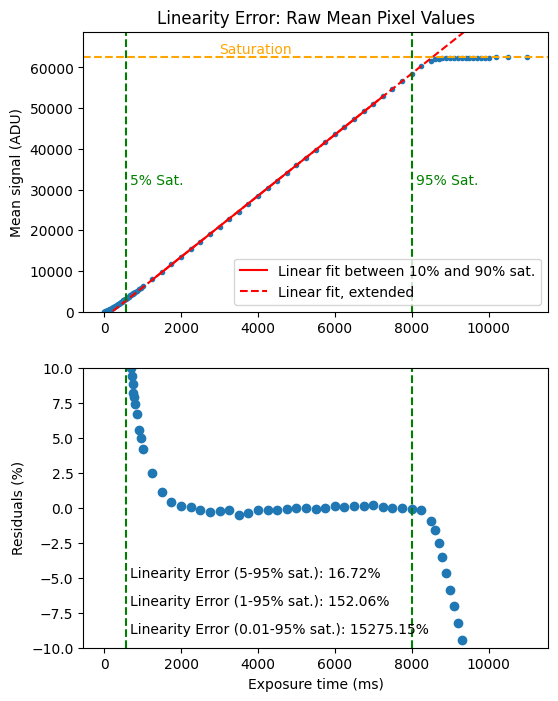

In [6]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(exp_times, mean_array, 'o', markersize=3)
popt_line = np.polyfit(exp_times[linear_regime_low_idx:linear_regime_high_idx],
                       mean_array[linear_regime_low_idx:linear_regime_high_idx], 1)
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval(popt_line, exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval(popt_line, exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].legend()
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
# Plot residuals
residuals_percent = (mean_array - np.polyval(popt_line, exp_times)) / mean_array * 100
ax[1].plot(exp_times, residuals_percent, 'o')
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
max_res_5_to_95 = np.max(residuals_percent[idx_5_percent:idx_95_percent])
min_res_5_to_95 = np.min(residuals_percent[idx_5_percent:idx_95_percent])
max_res_1_to_95 = np.max(residuals_percent[idx_1_percent:idx_95_percent])
min_res_1_to_95 = np.min(residuals_percent[idx_1_percent:idx_95_percent])
max_res_0_to_95 = np.max(residuals_percent[idx_tenthousandth:idx_95_percent])
min_res_0_to_95 = np.min(residuals_percent[idx_tenthousandth:idx_95_percent])
linearity_error_5_to_95 = max_res_5_to_95 - min_res_5_to_95
linearity_error_1_to_95 = max_res_1_to_95 - min_res_1_to_95
linearity_error_0_to_95 = max_res_0_to_95 - min_res_0_to_95
ax[1].text(exp_times[idx_5_percent] + 100, -5, f'Linearity Error (5-95% sat.): {linearity_error_5_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -7, f'Linearity Error (1-95% sat.): {linearity_error_1_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -9, f'Linearity Error (0.01-95% sat.): {linearity_error_0_to_95:.2f}%', ha='left')
ax[0].set_title('Linearity Error: Raw Mean Pixel Values')
plt.show()

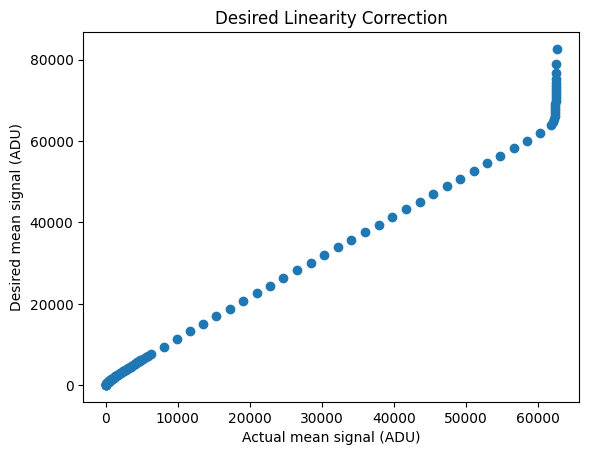

In [7]:
%matplotlib inline
# The values to which we want to correct the signal. Basically, we want to move all values
# such that they fall on the line that best fits the linear regime.
corrected_signal_vals = np.polyval(popt_line, exp_times)
# We want there to be no negative values in the corrected signal
corrected_signal_vals = corrected_signal_vals - popt_line[1]
# Add a bias level
bias_level = 100
corrected_signal_vals += bias_level
corrected_signal_vals = np.concatenate(([100], corrected_signal_vals))
mean_array_with_0 = np.concatenate(([0], mean_array))
plt.plot(mean_array_with_0, corrected_signal_vals, 'o')
plt.xlabel('Actual mean signal (ADU)')
plt.ylabel('Desired mean signal (ADU)')
plt.title('Desired Linearity Correction')
plt.show()

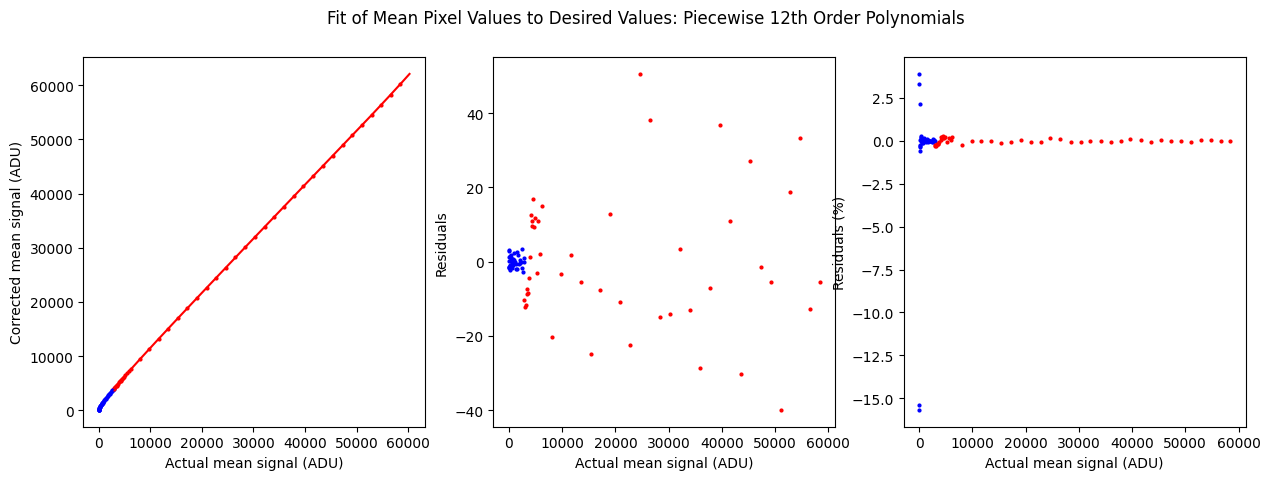

In [8]:
%matplotlib inline
# Fit mean_array_0 vs corrected_signal_vals to a polynomial fit. We want to see
# what order polynomial we should use to fit the data, and to see if a single fit to the mean
# pixel values can do a decent job of correcting the signals at all pixels.
# We will fit the data in two parts: the low end and the mid-to-high end, with some overlap between the fits.
transition_value = 3000
order_low = 12
order_high = 6
high_cutoff = 60000
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
transition_idx = np.argmax(mean_array_with_0 > transition_value)
high_cutoff_idx = np.argmax(mean_array_with_0 > high_cutoff)
high_cutoff_value = mean_array_with_0[high_cutoff_idx]
weights = np.ones_like(mean_array_with_0)
# Weight lower values higher
# weights[:10] *= 10
popt_poly_low = np.polyfit(mean_array_with_0[:transition_idx], corrected_signal_vals[:transition_idx],
                           order_low-1, w=weights[:transition_idx])
popt_poly_high = np.polyfit(mean_array_with_0[transition_idx-1:high_cutoff_idx],
                            corrected_signal_vals[transition_idx-1:high_cutoff_idx],
                            order_high-1, w=weights[transition_idx-1:high_cutoff_idx])
residuals_low = (corrected_signal_vals[:transition_idx] - np.polyval(popt_poly_low, mean_array_with_0[:transition_idx]))
residuals_high = (corrected_signal_vals[transition_idx-1:high_cutoff_idx] - np.polyval(popt_poly_high, mean_array_with_0[transition_idx-1:high_cutoff_idx]))
ax[0].plot(mean_array_with_0[:transition_idx], corrected_signal_vals[:transition_idx], 'bo', markersize=2,)
ax[0].plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], corrected_signal_vals[transition_idx-1:high_cutoff_idx], 'ro', markersize=2)
low_signal_vals = np.arange(0, transition_value, 1)
high_signal_vals = np.arange(transition_value, high_cutoff_value, 1)
ax[0].plot(low_signal_vals, np.polyval(popt_poly_low, low_signal_vals), 'blue')
ax[0].plot(high_signal_vals, np.polyval(popt_poly_high, high_signal_vals), 'red')
ax[0].set_xlabel('Actual mean signal (ADU)')
ax[0].set_ylabel('Corrected mean signal (ADU)')
# ax[0].set_title('Polynomial Fit')
ax[1].plot(mean_array_with_0[:transition_idx], residuals_low[:transition_idx], 'bo', markersize=2)
ax[1].plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], residuals_high, 'ro', markersize=2)
ax[1].set_xlabel('Actual mean signal (ADU)')
ax[1].set_ylabel('Residuals')
# ax[1].set_title('Polynomial Fit Residuals')
residuals_percent_low = residuals_low[1:] / (corrected_signal_vals[1:transition_idx] - bias_level) * 100
residuals_percent_high = residuals_high / (corrected_signal_vals[transition_idx-1:high_cutoff_idx] - bias_level) * 100
ax[2].plot(mean_array_with_0[1:transition_idx], residuals_percent_low, 'bo', markersize=2)
ax[2].plot(mean_array_with_0[transition_idx-1:high_cutoff_idx], residuals_percent_high, 'ro', markersize=2)
ax[2].set_xlabel('Actual mean signal (ADU)')
ax[2].set_ylabel('Residuals (%)')
# ax[1].set_title('Polynomial Fit Residuals')
plt.suptitle('Fit of Mean Pixel Values to Desired Values: Piecewise 12th Order Polynomials')
plt.show()

In [9]:
def correct_images(image_stack, coeffs, transition_value, high_cutoff, bits, order_low, bias_frame=None, verbose=False):
    corrected_stack = np.zeros_like(image_stack, dtype=np.uint16)
    order_high = len(coeffs) - order_low
    if bias_frame is not None:
        image_stack = image_stack - bias_frame
    for i, frame in enumerate(image_stack):
        corrected_frame = np.zeros_like(frame, dtype=float)
        low_vals_frame = np.zeros_like(frame)
        low_vals_frame[frame <= transition_value] = frame[frame <= transition_value]
        low_vals_true_frame = frame <= transition_value
        high_vals_frame = np.zeros_like(frame)
        high_vals_frame[(frame > transition_value) & (frame < high_cutoff)] = frame[(frame > transition_value) & (frame < high_cutoff)]
        high_vals_true_frame = (frame > transition_value) & (frame < high_cutoff)
        saturated_vals_true_frame = frame >= high_cutoff
        for j in range(order_low - 1):
            corrected_frame += coeffs[j] * low_vals_frame.astype(float) ** (order_low - 1 - j)
        for j in range(order_high - 1):
            corrected_frame += coeffs[j + order_low] * high_vals_frame.astype(float) ** (order_high - 1 - j)
            # For saturated values, set the corrected value to the correction of high_cutoff
            corrected_frame += coeffs[j + order_low] * (high_cutoff * saturated_vals_true_frame).astype(float) ** (order_high - 1 - j)
        # Add the correct constant term
        corrected_frame += coeffs[order_low - 1] * low_vals_true_frame
        corrected_frame += coeffs[-1] * high_vals_true_frame
        corrected_frame += coeffs[-1] * saturated_vals_true_frame
        # Bound corrected_frame between 0 and 2**bits - 1
        corrected_frame[corrected_frame < 0] = 0
        corrected_frame[corrected_frame > 2**bits - 1] = 2**bits - 1
        # Make NaNs equal to 2 ** bits - 1
        corrected_frame[np.isnan(corrected_frame)] = 2 ** bits - 1
        corrected_stack[i] = np.rint(corrected_frame).astype(np.uint16)
        if verbose:
            print(i, np.median(corrected_stack[i]))
    return corrected_stack

In [10]:
coeffs_mean = np.concatenate((popt_poly_low, popt_poly_high))
corrected_mean_array = correct_images(mean_array_with_0[1:], coeffs_mean, transition_value, high_cutoff, 16, order_low=order_low)
max_signal = np.max(corrected_mean_array) - bias_level
idx_95_percent = np.where(corrected_mean_array - bias_level <= max_signal * 0.95)[0][-1]
idx_50_percent = np.where(corrected_mean_array - bias_level <= max_signal * 0.5)[0][-1]
idx_5_percent = np.where(corrected_mean_array - bias_level >= max_signal * 0.05)[0][0]
idx_1_percent = np.where(corrected_mean_array - bias_level >= max_signal * 0.01)[0][0]
idx_tenthousandth = np.where(corrected_mean_array - bias_level >= max_signal * 0.0001)[0][0]

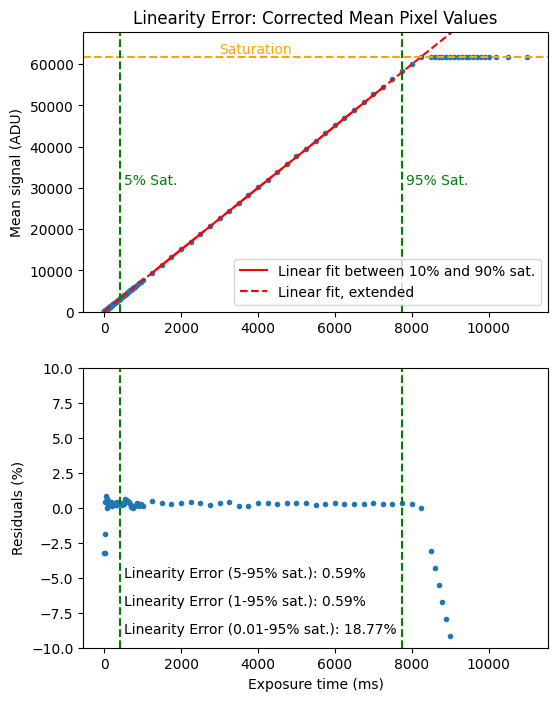

In [11]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(exp_times, corrected_mean_array, 'o', markersize=3)
# Fit to line with intercept bias_level
popt_1, pcov_1 = curve_fit(lambda x, m: m * x + bias_level, exp_times[idx_5_percent:idx_95_percent],
                   corrected_mean_array[idx_5_percent:idx_95_percent] - bias_level)
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_1[0], bias_level], exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval([popt_1[0], bias_level], exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].legend()
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
# Plot residuals
residuals_percent = (corrected_mean_array - np.polyval([popt_1[0], bias_level], exp_times)) / (corrected_mean_array - bias_level) * 100
ax[1].plot(exp_times, residuals_percent, 'o', markersize=3)
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
max_res_5_to_95 = np.max(residuals_percent[idx_5_percent:idx_95_percent])
min_res_5_to_95 = np.min(residuals_percent[idx_5_percent:idx_95_percent])
max_res_1_to_95 = np.max(residuals_percent[idx_1_percent:idx_95_percent])
min_res_1_to_95 = np.min(residuals_percent[idx_1_percent:idx_95_percent])
max_res_0_to_95 = np.max(residuals_percent[idx_tenthousandth:idx_95_percent])
min_res_0_to_95 = np.min(residuals_percent[idx_tenthousandth:idx_95_percent])
linearity_error_5_to_95 = max_res_5_to_95 - min_res_5_to_95
linearity_error_1_to_95 = max_res_1_to_95 - min_res_1_to_95
linearity_error_0_to_95 = max_res_0_to_95 - min_res_0_to_95
ax[1].text(exp_times[idx_5_percent] + 100, -5, f'Linearity Error (5-95% sat.): {linearity_error_5_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -7, f'Linearity Error (1-95% sat.): {linearity_error_1_to_95:.2f}%', ha='left')
ax[1].text(exp_times[idx_5_percent] + 100, -9, f'Linearity Error (0.01-95% sat.): {linearity_error_0_to_95:.2f}%', ha='left')
ax[0].set_title('Linearity Error: Corrected Mean Pixel Values')
plt.show()

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_49528/972875884.py:14: RuntimeWarning: divide by zero encountered in divide
  pixel_residuals_percent =  pixel_residuals / (pixel_corrected_values - bias_level) * 100


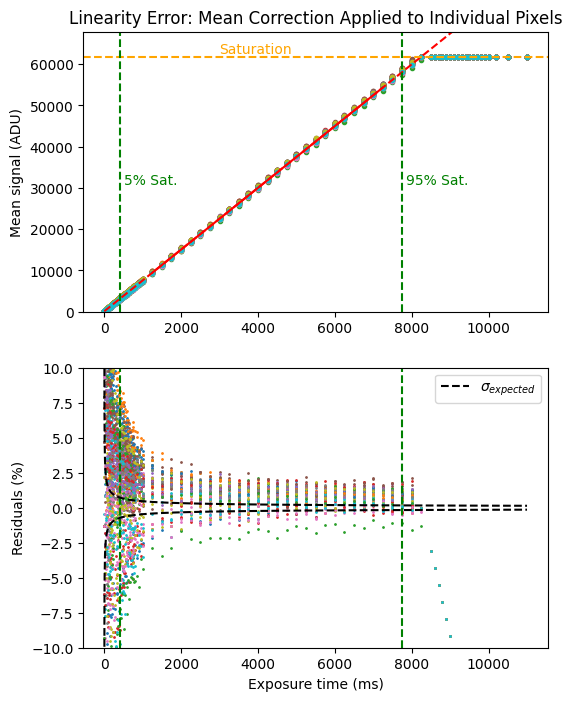

In [12]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
square_size = 100
test_subtracted_images = subtracted_images[:, 4000:4000+square_size, 4000:4000+square_size]
corrected_test_images = correct_images(test_subtracted_images, coeffs_mean, transition_value, high_cutoff, 16, order_low=order_low)
# Collect the percent residual at each pixels for 95%, 50%, 5%, 1%, and 0.01% saturation.
# If the calibration is not biased high or low, the mean of these values should be zero,
# and the standard deviation should be close to the expected noise level from shot noise, read noise, and quantization noise.
err_vals = np.zeros((square_size, square_size, 5))
for i in range(square_size):
    for j in range(square_size):
        pixel_corrected_values = corrected_test_images[:, i, j]
        pixel_residuals = (pixel_corrected_values - np.polyval([popt_1[0], bias_level], exp_times))
        pixel_residuals_percent =  pixel_residuals / (pixel_corrected_values - bias_level) * 100
        if i * square_size + j < 50:
            ax[0].plot(exp_times, pixel_corrected_values, 'o', markersize=3)
            ax[1].plot(exp_times, pixel_residuals_percent, 'o', markersize=1)
        err_vals[i, j, 0] = pixel_residuals[idx_95_percent]
        err_vals[i, j, 1] = pixel_residuals[idx_50_percent]
        err_vals[i, j, 2] = pixel_residuals[idx_5_percent]
        err_vals[i, j, 3] = pixel_residuals[idx_1_percent]
        err_vals[i, j, 4] = pixel_residuals[idx_tenthousandth] if not np.isinf(pixel_residuals[idx_tenthousandth]) else np.nan
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_1[0], bias_level], exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval([popt_1[0], bias_level], exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
# ax[1].text(exp_times[idx_5_percent] + 1000, 8, r'$\mu_{95\%}: $' + format(mu_errs[0], '.2f') + '%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 200, -7, f'Avg. Linearity Error (1-95% sat.): {avg_lin_err_1_to_95:.2f}%', ha='left')
# ax[1].text(exp_times[idx_5_percent] + 200, -9, f'Avg. Linearity Error (0.01-95% sat.): {avg_lin_err_0_to_95:.2f}%', ha='left')
num_frames = 25
gain = 4
read_noise = 2
# Expected noise from shot noise, read noise, and quantization noise (which is 1/12 corrected ADU)
expected_errs = np.sqrt((gain * (np.polyval([popt_1[0], bias_level], exp_times) - bias_level) + gain ** 2 * read_noise) / num_frames + 1 / 12) / (np.polyval([popt_1[0], bias_level], exp_times) - bias_level) * 100
ax[1].plot(exp_times, expected_errs, 'k--', label=r'$\sigma_{expected}$')
ax[1].plot(exp_times, -expected_errs, 'k--')
ax[1].legend()
ax[0].set_title('Linearity Error: Mean Correction Applied to Individual Pixels')
plt.show()
means_list = np.array([corrected_mean_array[i] - bias_level for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
mu_errs = np.nanmean(err_vals, axis=(0, 1)) / means_list * 100
sigma_errs = np.nanstd(err_vals, axis=(0, 1)) / means_list * 100
sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_tenthousandth]]


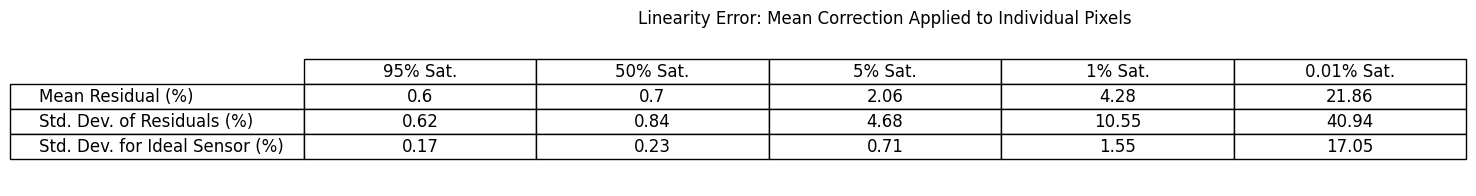

In [13]:
# Data for the table
table_data = [
    [round(mu_errs[0], 2), round(mu_errs[1], 2), round(mu_errs[2], 2), round(mu_errs[3], 2), round(mu_errs[4], 2)],
    [round(sigma_errs[0], 2), round(sigma_errs[1], 2), round(sigma_errs[2], 2), round(sigma_errs[3], 2), round(sigma_errs[4], 2)],
    [round(sigma_expected[0], 2), round(sigma_expected[1], 2), round(sigma_expected[2], 2), round(sigma_expected[3], 2), round(sigma_expected[4], 2)]
]

# Column labels
column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.01% Sat."]
row_labels = ["Mean Residual (%)", "Std. Dev. of Residuals (%)", "Std. Dev. for Ideal Sensor (%)"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Linearity Error: Mean Correction Applied to Individual Pixels')
# Display the table
plt.show()

Indeed, it is necessary to do totally separate nonlinearity corrections for every pixel. And you cannot just use a correction for each row or each pixel. Even directly adjacent pixels can be very different.

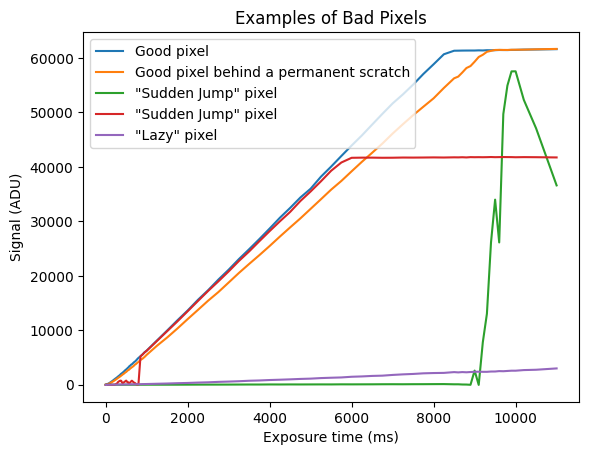

In [14]:
%matplotlib inline
# Need to figure out how to weed out bad pixels during calibration.
# Otherwise their weird curves will just result in a really weird calibration
# that may temporaily hide their weird behavior
# Some behaviors that should disqualify pixels:
# 1) They very quickly go from very little signal to saturation
# 2) They don't even come close to saturating
# 3) Their response w/r/t exposure time is not monotonically increasing.
# The 3rd one seems to be included in the other 2, but it's worth checking for.
signal_shootup_cutoff = 4000
lazy_pix_signal_cutoff = 10000
plt.plot(exp_times, subtracted_images[:, 7184, 50], label='Good pixel')
plt.plot(exp_times, subtracted_images[:, 7069, 2422], label='Good pixel behind a permanent scratch')
plt.plot(exp_times, subtracted_images[:, 7184, 54], label='"Sudden Jump" pixel')
plt.plot(exp_times, subtracted_images[:, 4000, 994], label='"Sudden Jump" pixel')
plt.plot(exp_times, subtracted_images[:, 7184, 53], label='"Lazy" pixel')
# for i in range(10):
#     plt.scatter(exp_times, subtracted_images[:, 4000 + i, 994], label=i, s=3)
plt.legend()
plt.xlabel('Exposure time (ms)')
plt.ylabel('Signal (ADU)')
plt.title('Examples of Bad Pixels')
plt.show()

In [15]:
order_low = 12
order_high = 6
transition_value = 3000
high_cutoff = 60000
coeff_array = np.zeros((order_low + order_high, 8120, 8120))

Non-monotonically increasing pixel at  0 994
Non-monotonically increasing pixel at  1 994
Non-monotonically increasing pixel at  2 994
Non-monotonically increasing pixel at  3 994
Non-monotonically increasing pixel at  4 994
Non-monotonically increasing pixel at  5 994
Non-monotonically increasing pixel at  6 994
Non-monotonically increasing pixel at  7 994
Non-monotonically increasing pixel at  8 994
Non-monotonically increasing pixel at  9 994
Non-monotonically increasing pixel at  10 994
Non-monotonically increasing pixel at  11 994
Non-monotonically increasing pixel at  12 994
Non-monotonically increasing pixel at  13 994
Non-monotonically increasing pixel at  14 994
Non-monotonically increasing pixel at  15 994
Non-monotonically increasing pixel at  16 994
Non-monotonically increasing pixel at  17 994
Non-monotonically increasing pixel at  18 994
Non-monotonically increasing pixel at  19 994
Non-monotonically increasing pixel at  20 994
Non-monotonically increasing pixel at  21 99

KeyboardInterrupt: 

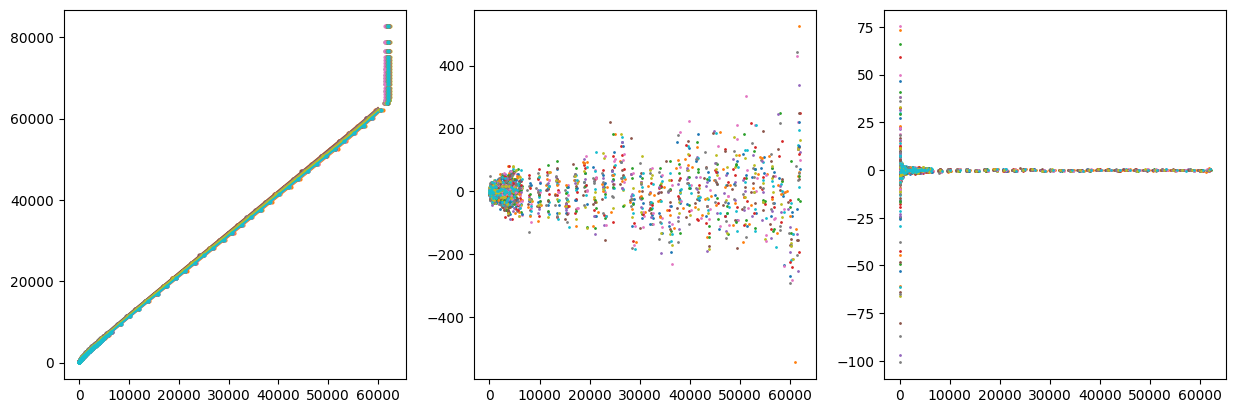

In [36]:
%matplotlib inline
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
num_plots = 0
for i in range(0,1000):
    for j in range(8120):
        # if j == 0:
        #     print(i, j)
        mean_vals = subtracted_images[:, i, j]
        mean_vals = np.concatenate(([0], mean_vals))
            
        # Identify defect pixels. First, lazy pixels.
        if np.max(mean_vals) < lazy_pix_signal_cutoff:
            print('Lazy Pixel at ', i, j)
            # Make the coefficients NaNs if pixel is lazy
            coeff_array[:, i, j] = np.nan
            continue
        # Next, pixels whose signal suddenly shoots up at some exposure time
        if np.any(np.diff(mean_vals) > signal_shootup_cutoff):
            print('Sudden jump pixel at ', i, j)
            coeff_array[:, i, j] = np.nan
            continue
        # Finally, pixels whose signals are not monotonically increasing, at least where the sensor
        # as a whole should be in the linear regime (so noise wouldn't cause such behavior)
        if not np.all(np.diff(mean_vals[linear_regime_low_idx:linear_regime_high_idx]) > 0):
            print('Non-monotonically increasing pixel at ', i, j)
            coeff_array[:, i, j] = np.nan
            continue
        
        # Split the data into low and high regimes for fitting
        transition_idx = np.argmax(mean_vals > transition_value)
        # Don't want the fit to go above saturation. high_cutoff is a bit
        # below saturation, so we fit to just beyond that point.
        if np.max(mean_vals) > high_cutoff:
            high_cutoff_idx = np.argmax(mean_vals > high_cutoff)
            high_cutoff_value = mean_vals[high_cutoff_idx]
        # If pixel isn't reaching saturation, fit to the highest value
        else:
            high_cutoff_idx = len(mean_vals) - 2
            high_cutoff_value = mean_vals[high_cutoff_idx]
        weights = np.ones_like(mean_vals[:transition_idx+2])
        # weights[:10] *= 10
        # weights = 1 / (1 + np.sqrt(abs(mean_vals[:transition_idx+2])))
        popt_poly_low = np.polyfit(mean_vals[:transition_idx+2], corrected_signal_vals[:transition_idx+2], deg=order_low-1, w=weights)
        popt_poly_high = np.polyfit(mean_vals[transition_idx-1:high_cutoff_idx+2],
                                    corrected_signal_vals[transition_idx-1:high_cutoff_idx+2], deg=order_high-1)
        coeff_array[:, i, j] = np.concatenate((popt_poly_low, popt_poly_high))
        residuals_low = corrected_signal_vals[1:transition_idx+2] - np.polyval(popt_poly_low, mean_vals[1:transition_idx+2])
        residuals_high = corrected_signal_vals[transition_idx-1:high_cutoff_idx+2] - np.polyval(popt_poly_high, mean_vals[transition_idx-1:high_cutoff_idx+2])
        residuals_percent_low = residuals_low / (corrected_signal_vals[1:transition_idx+2] - bias_level) * 100
        residuals_percent_high = residuals_high / (corrected_signal_vals[transition_idx-1:high_cutoff_idx+2] - bias_level) * 100
        low_vals_plot = np.arange(-10, transition_value, 0.5)
        high_vals_plot = np.arange(transition_value, high_cutoff, 0.5)
        all_ints_low = np.arange(0, transition_value, 1)
        if num_plots < 30:
            ax[0].plot(mean_vals, corrected_signal_vals, 'o', markersize=2, label=f'Pixel {i}, {j}')
            ax[0].plot(low_vals_plot, np.polyval(popt_poly_low, low_vals_plot), c=ax[0].lines[-1].get_color())
            ax[0].plot(high_vals_plot, np.polyval(popt_poly_high, high_vals_plot), c=ax[0].lines[-1].get_color())
            ax[0].plot(all_ints_low, np.polyval(popt_poly_low, all_ints_low), c=ax[0].lines[-1].get_color())
            ax[1].plot(mean_vals[1:transition_idx+2], residuals_low, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[1].plot(mean_vals[transition_idx-1:high_cutoff_idx+2], residuals_high, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[2].plot(mean_vals[1:transition_idx+2], residuals_percent_low, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            ax[2].plot(mean_vals[transition_idx-1:high_cutoff_idx+2], residuals_percent_high, 'o', markersize=1, c=ax[0].lines[-1].get_color())
            num_plots += 1

# ax[0].legend()
ax[0].set_xlabel('Mean Pixel Signal (ADU)')
ax[0].set_ylabel('Corrected Mean Pixel Signal (ADU)')
# ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_xlabel('Mean signal (ADU)')
ax[1].set_ylabel('Residuals of Fit (Adu)')
ax[1].set_ylim(-100, 100)
ax[2].set_xlabel('Mean signal (ADU)')
ax[2].set_ylabel('Residuals of Fit (%)')
ax[2].set_ylim(-100, 100)
# label_plot(gray_stacks[0])
plt.show()

In [17]:
corrected_images = correct_images(subtracted_images[:,4000:4100,4000:4100], coeff_array[:,4000:4100,4000:4100],
                                  transition_value=transition_value, high_cutoff=high_cutoff,
                                  bits=16, verbose=False, order_low=order_low)
corrected_image_means = np.mean(corrected_images, axis=(1,2))
# Fit to line with intercept of bias_level
popt_2, pcov_2 = curve_fit(lambda x, m: m * x + bias_level, exp_times[linear_regime_low_idx:linear_regime_high_idx],
                          corrected_image_means[linear_regime_low_idx:linear_regime_high_idx] - bias_level)


/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_49528/2570739027.py:12: RuntimeWarning: divide by zero encountered in divide
  pixel_residuals_percent = pixel_residuals / (pixel_corrected_values - bias_level) * 100


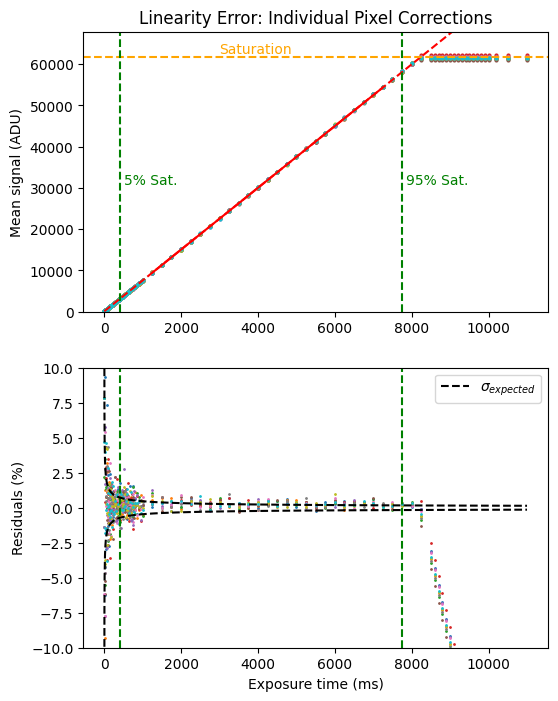

In [32]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
square_size = 50
# Collect the percent residual at each pixels for 95%, 50%, 5%, 1%, and 0.01% saturation.
# If the calibration is not biased high or low, the mean of these values should be zero,
# and the standard deviation should be close to the expected noise level from shot noise, read noise, and quantization noise.
err_vals = np.zeros((square_size, square_size, 5))
for i in range(square_size):
    for j in range(square_size):
        pixel_corrected_values = corrected_images[:, i, j]
        pixel_residuals = pixel_corrected_values - np.polyval([popt_2[0], bias_level], exp_times)
        pixel_residuals_percent = pixel_residuals / (pixel_corrected_values - bias_level) * 100
        if i * square_size + j < 10:
            ax[0].plot(exp_times, pixel_corrected_values, 'o', markersize=2)
            ax[1].plot(exp_times, pixel_residuals_percent, 'o', markersize=1)
        err_vals[i, j, 0] = pixel_residuals[idx_95_percent]
        err_vals[i, j, 1] = pixel_residuals[idx_50_percent]
        err_vals[i, j, 2] = pixel_residuals[idx_5_percent]
        err_vals[i, j, 3] = pixel_residuals[idx_1_percent]
        err_vals[i, j, 4] = pixel_residuals[idx_tenthousandth] if not np.isinf(pixel_residuals[idx_tenthousandth]) else np.nan
        
ax[0].plot(exp_times[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_2[0], bias_level], exp_times[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times, np.polyval([popt_2[0], bias_level], exp_times), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
ax[1].axvline(exp_times[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
# Add curves showing expected linearity error from shot noise plus read noise
num_frames = 25
gain = 4
read_noise = 2
expected_errs = np.sqrt((gain * (np.polyval([popt_2[0], bias_level], exp_times) - bias_level) + gain ** 2 * read_noise) / num_frames + 1 / 12) / (np.polyval([popt_2[0], bias_level], exp_times) - bias_level) * 100
ax[1].plot(exp_times, expected_errs, 'k--', label=r'$\sigma_{expected}$')
ax[1].plot(exp_times, -expected_errs, 'k--')
ax[1].legend()
ax[0].set_title('Linearity Error: Individual Pixel Corrections')
plt.show()
corrected_means_list = np.array([corrected_image_means[i] - bias_level
                                              for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
mu_errs = np.nanmean(err_vals, axis=(0, 1)) / corrected_means_list * 100
sigma_errs = np.nanstd(err_vals, axis=(0, 1)) / corrected_means_list * 100
sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_tenthousandth]]

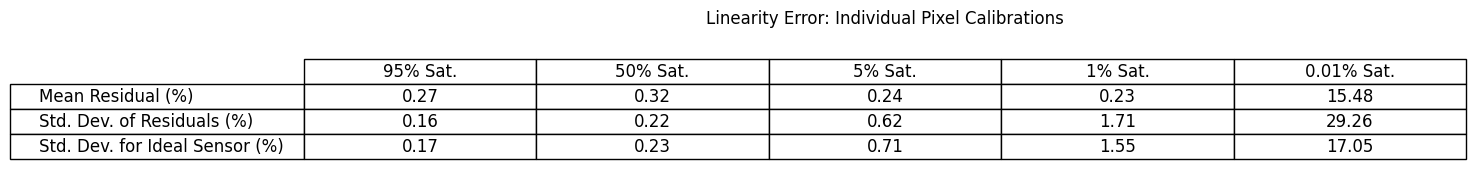

In [33]:
%matplotlib inline
# Data for the table
table_data = [
    [round(mu_errs[0], 2), round(mu_errs[1], 2), round(mu_errs[2], 2), round(mu_errs[3], 2), round(mu_errs[4], 2)],
    [round(sigma_errs[0], 2), round(sigma_errs[1], 2), round(sigma_errs[2], 2), round(sigma_errs[3], 2), round(sigma_errs[4], 2)],
    [round(sigma_expected[0], 2), round(sigma_expected[1], 2), round(sigma_expected[2], 2), round(sigma_expected[3], 2), round(sigma_expected[4], 2)]
]

# Column labels
column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.01% Sat."]
row_labels = ["Mean Residual (%)", "Std. Dev. of Residuals (%)", "Std. Dev. for Ideal Sensor (%)"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Linearity Error: Individual Pixel Calibrations')
# Display the table
plt.show()

In [20]:
# Save coefficient array as a fits file
# hdu = fits.PrimaryHDU(coeff_array)
# hdu.writeto('coeff_array.fits', overwrite=True)

Process for conducting calibration on new images:
1) Find the average uncalibrated dark frame, denoted D_raw
2) Subtract the mean bias frame used to construct the calibration, B_base from D_raw to get D_sub. 
3) Apply calibration (run correct_images with appropriate coefficient array) to D_sub to get the calibrated dark frame D_cal.
4) For each raw light frame F_raw, subtract B_base from F_raw to get F_sub.
5) Apply calibration to F_sub to get F_int.
6) Subtract D_cal from F_int to get the final calibrated, dark-subtracted frame F_cal. Apply the same flat-fielding techniques using F_cal frames.

If you're applying the calibration to analyze dark frames or bias frames, you may want to collect a new set of bias frames, and treat the average of these raw bias frames as D_raw. Then apply the calibration the same way as above, replacing light frames with your individual bias or dark frames.

In [21]:
# # Correct a stack of bias frames and calculate the read noise using the calibration
# read_noise_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise'
# read_noise_stack = get_stacks(read_noise_folder, get_mean_img=True)

In [22]:
# subtracted_biases = read_noise_stack[0]['imagestack'] - read_noise_stack[0]['mean_img']
# # Correct subtracted bias images
# corrected_subtracted_biases = correct_images(subtracted_biases[:,4000:4010,:8120], coeff_array[:,4000:4010,:8120], transition_value, high_cutoff, 16, order_low=order_low)

In [23]:
# plt.hist(corrected_subtracted_biases.flatten(), bins=200, range=(0,200))
# plt.xlabel('Corrected subtracted bias values (ADU)')
# plt.ylabel('Number of pixels')
# plt.yscale('log')
# plt.show()


In [24]:
# %matplotlib inline
# gain = 4 # ADU/e-
# read_noise_array = np.std(corrected_subtracted_biases, axis=0) / 4
# plt.hist(read_noise_array.flatten(), bins=200, range=(0,10))
# plt.xlabel('Read noise values (e-)')
# plt.ylabel('Number of pixels')
# plt.yscale('log')
# plt.show()

In [25]:
# # For every fits file corresponding to an image stack, calculate the average image and save this as a new fits file with the same header
# data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab data/10-5-2024/CMS'
# mean_images_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/CMS'
# fits_files = [f for f in os.listdir(data_folder) if f.endswith('.fits')]
# for i, file in enumerate(fits_files[84:]):
#     print(i+84, file)
#     hdul = fits.open(os.path.join(data_folder, file))
#     data = hdul[0].data
#     mean_img = np.mean(data, axis=0).astype(np.float32)
#     # Save the mean image as a new fits file, but use the same header
#     hdu = fits.PrimaryHDU(mean_img)
#     if 'dark' in file:
#         folder = mean_images_folder + '/Dark Verification Mean Images'
#         hdu.writeto(os.path.join(folder, f'mean_{file}'), overwrite=True)
#     elif 'light' in file:
#         folder = mean_images_folder + '/Light Verification Mean Images'
#         hdu.writeto(os.path.join(folder, f'mean_{file}'), overwrite=True)
#     hdul.close()

A few notes on various nonlinear calibration techniques:
- Polynomial fits: even at high order, don't do a good job of capturing low-signal response. Easy to implement and fast on GPUs.
- Polynomial fits with square root/power law: more complicated, better than polynomial, but still not great for low signal levels
- Rational fits: do better at capturing low-signal response, but have the potential to produce roots in the demoninator that make the calibrated number of photoelectrons go to infinity
- Cubic Splines: obviously fit the data exactly, but introduce many areas of the parameter space of signal levels where increasing signal levels calibrate to decreasing photoelectron value (cubic splines are not monotonic). A bit more complicated to implement on a GPU (can think of cubic splines for one pixel as O(100) separate cubic polynomials), but it's manageable.
- Linear Interpolation: like cubic splines, calibration is more complicated to implement on GPU, but a little less demanding. Will naturally fit the calibration data exactly, and will always be monotonically increasing, assuming the calibration data is.

In [26]:
# Verification of calibration
verification_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonlinearity Calibration/CMS'
dark_folder_2 = os.path.join(verification_folder, 'Dark Verification Mean Images')
light_folder_2 = os.path.join(verification_folder, 'Light Verification Mean Images')
dark_files_2 = [f for f in os.listdir(dark_folder_2) if f.endswith('.fits')]
light_files_2 = [f for f in os.listdir(light_folder_2) if f.endswith('.fits')]
# Sort files by exposure time
exp_times_light_2 = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files_2]
exp_times_dark_2 = [float(f.split('s_')[0].split('_')[-1][:-1]) for f in dark_files_2]
# Sort light files by exposure time
light_files_2 = [x for _, x in sorted(zip(exp_times_light_2, light_files_2))]
dark_files_2 = [x for _, x in sorted(zip(exp_times_dark_2, dark_files_2))]
# Swap 1st and 2nd entries for both so 1 us comes before 1 ms
temp = light_files_2[0]
light_files_2[0] = light_files_2[1]
light_files_2[1] = temp
temp = dark_files_2[0]
dark_files_2[0] = dark_files_2[1]
dark_files_2[1] = temp
exp_times_2 = np.array([float(f.split('s_')[0].split('_')[-1][:-1]) for f in light_files_2])
exp_times_2[0] = exp_times_2[0] / 1000
# Need to adjust exposure times for actual exposure times.
# Minimum exposure times:
# CMS: 1354 us
# HS_HG_RS: 38 us
# HS_HG_GS: 27028 us
# Row times (exposure times must be integer multiples of these):
# CMS: 150.5 us
# HS_HG_RS: 5.4 us
# HS_HG_GS: 3.3 us
min_exp_time = 1354 / 1000
row_time = 150.5 / 1000
# For any exposure time less than min_exp_time, set to min_exp_time
exp_times_2[exp_times_2 < min_exp_time] = min_exp_time
# Round exposure times to nearest integer multiple of row_time
exp_times_2 = np.rint(exp_times_2 / row_time) * row_time

subtracted_images_2 = np.zeros((len(light_files_2), 8120, 8120), dtype=np.float32)
mean_array_2 = np.zeros(len(light_files_2))
mean_bias_frame_2_hdul = fits.open(os.path.join(dark_folder_2, dark_files_2[0]))
mean_bias_frame_2 = mean_bias_frame_2_hdul[0].data
mean_bias_frame_2_hdul.close()
mean_bias_frame_2 = mean_bias_frame_2 - mean_bias_frame
for i in range(len(light_files_2)):
    hdul_light = fits.open(os.path.join(light_folder_2, light_files_2[i]))
    # hdul_dark = fits.open(os.path.join(dark_folder_2, dark_files_2[i]))
    data_light = hdul_light[0].data
    # data_dark = hdul_dark[0].data
    # subtracted_image = data_light - data_dark
    subtracted_image = data_light - mean_bias_frame
    mean_val = np.mean(subtracted_image)
    subtracted_images_2[i] = subtracted_image
    mean_array_2[i] = mean_val
    hdul_light.close()
    # hdul_dark.close()
    print(i, exp_times_2[i], mean_val)

0 1.3545 2.646771
1 1.3545 2.657626
2 4.9665 9.682898
3 9.933 20.443289
4 20.0165 45.116787
5 29.9495 74.05243
6 40.033 105.73228
7 49.966 140.79977
8 60.049499999999995 178.04257
9 69.9825 218.12096
10 80.066 260.36148
11 89.999 304.60974
12 99.932 350.66666
13 110.0155 398.97046
14 119.9485 447.08084
15 130.03199999999998 498.11816
16 139.965 548.184
17 150.0485 600.2763
18 159.98149999999998 653.5693
19 170.065 709.54175
20 179.998 764.6797
21 189.93099999999998 819.64075
22 200.0145 875.76373
23 220.031 990.509
24 240.04749999999999 1110.0186
25 260.06399999999996 1231.7382
26 279.93 1354.7186
27 299.9465 1479.2545
28 319.96299999999997 1605.0542
29 339.9795 1731.0133
30 359.996 1858.788
31 380.0125 1991.002
32 400.029 2119.9978
33 420.0455 2252.524
34 440.062 2385.7305
35 459.928 2522.5503
36 479.9445 2652.2605
37 499.96099999999996 2785.675
38 519.9775 2922.7659
39 539.994 3051.8638
40 560.0105 3192.4343
41 580.0269999999999 3323.2622
42 600.0435 3467.789
43 620.06 3612.6506
44 6

In [27]:
corrected_verification_images = correct_images(subtracted_images_2[:,4000:4100,4000:4100], coeff_array[:,4000:4100,4000:4100], transition_value, high_cutoff, 16, order_low=order_low)
corrected_bias_frame_2 = correct_images([mean_bias_frame_2[4000:4100,4000:4100]], coeff_array[:,4000:4100,4000:4100], transition_value, high_cutoff, 16, order_low=order_low)
# corrected_verification_images = corrected_verification_images - corrected_bias_frame_2 + bias_level
corrected_verification_means = np.mean(corrected_verification_images, axis=(1,2))
# Find the best fit line with an intercept of bias_level
popt_3, pcov_3 = curve_fit(lambda x, m: m * x + bias_level, exp_times_2[linear_regime_low_idx:linear_regime_high_idx],
                           corrected_verification_means[linear_regime_low_idx:linear_regime_high_idx])

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_49528/125760727.py:15: RuntimeWarning: divide by zero encountered in divide
  pixel_residuals_percent = pixel_residuals / (pixel_corrected_values - bias_level) * 100


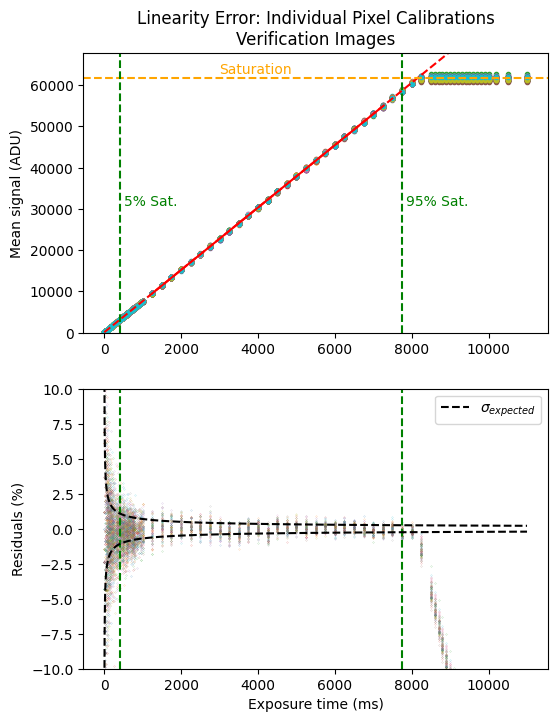

In [34]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
square_size = 50
# Collect the percent residual at each pixels for 95%, 50%, 5%, 1%, and 0.01% saturation.
# If the calibration is not biased high or low, the mean of these values should be zero,
# and the standard deviation should be close to the expected noise level from shot noise, read noise, and quantization noise.
err_vals = np.zeros((square_size, square_size, 5))
err_vals_2 = np.zeros((square_size, square_size, 5))
for i in range(square_size):
    for j in range(square_size):
        pixel_corrected_values = corrected_verification_images[:, i, j]
        # Only find residuals for nonzero elements of pixel_corrected_values
        idx_nonzero = np.nonzero(pixel_corrected_values)
        pixel_residuals = (pixel_corrected_values - np.polyval([popt_3[0], 100], exp_times_2))
        pixel_residuals_percent = pixel_residuals / (pixel_corrected_values - bias_level) * 100
        if i * square_size + j < 100:
            ax[0].plot(exp_times_2, pixel_corrected_values, 'o', markersize=3)
            ax[1].plot(exp_times_2, pixel_residuals_percent, 'o', markersize=0.1)
        err_vals[i, j, 0] = pixel_residuals[idx_95_percent]
        err_vals[i, j, 1] = pixel_residuals[idx_50_percent]
        err_vals[i, j, 2] = pixel_residuals[idx_5_percent]
        err_vals[i, j, 3] = pixel_residuals[idx_1_percent]
        err_vals[i, j, 4] = pixel_residuals[idx_tenthousandth] if not np.isinf(pixel_residuals[idx_tenthousandth]) else np.nan

ax[0].plot(exp_times_2[linear_regime_low_idx:linear_regime_high_idx], 
           np.polyval([popt_3[0], 100], exp_times_2[linear_regime_low_idx:linear_regime_high_idx]),
           c='r', label='Linear fit between 10% and 90% sat.')
ax[0].plot(exp_times_2, np.polyval([popt_3[0], 100], exp_times_2), c='r', linestyle='--',
           label='Linear fit, extended')
ax[0].axhline(max_signal, color='orange', linestyle='--')
ax[0].text(3000, max_signal + 1000, 'Saturation', color='orange')
# Put vertical lines at 0%, 5%, 95%, and 100% saturation
ax[0].axvline(exp_times_2[idx_5_percent], color='g', linestyle='--')
ax[0].axvline(exp_times_2[idx_95_percent], color='g', linestyle='--')
# Label vertical lines as 5% saturation and 95% saturation
ax[0].text(exp_times_2[idx_5_percent] + 100, 0.5 * max_signal, '5% Sat.', color='g')
ax[0].text(exp_times_2[idx_95_percent] + 100, 0.5 * max_signal, '95% Sat.', color='g')
ax[0].set_ylabel('Mean signal (ADU)')
ax[0].set_ylim(0, max_signal * 1.1)
ax[1].axvline(exp_times_2[idx_5_percent], color='g', linestyle='--')
ax[1].axvline(exp_times_2[idx_95_percent], color='g', linestyle='--')
ax[1].set_xlabel('Exposure time (ms)')
ax[1].set_ylabel('Residuals (%)')
ax[1].set_ylim(-10, 10)
num_frames = 11
gain = 4
read_noise = 2
expected_errs = np.sqrt((gain * (np.polyval([popt_3[0], bias_level], exp_times) - bias_level) + gain ** 2 * read_noise) / num_frames + 1 / 12) / (np.polyval([popt_3[0], bias_level], exp_times) - bias_level) * 100
ax[1].plot(exp_times, expected_errs, 'k--', label=r'$\sigma_{expected}$')
ax[1].plot(exp_times, -expected_errs, 'k--')
ax[1].legend()
ax[0].set_title('Linearity Error: Individual Pixel Calibrations\nVerification Images')
plt.show()
corrected_verification_means_list = np.array([corrected_verification_means[i] - bias_level
                                              for i in [idx_95_percent, idx_50_percent, idx_5_percent, idx_1_percent, idx_tenthousandth]])
mu_errs = np.nanmean(err_vals, axis=(0, 1)) / corrected_verification_means_list * 100
sigma_errs = np.nanstd(err_vals, axis=(0, 1)) / corrected_verification_means_list * 100
sigma_expected = [expected_errs[idx_95_percent], expected_errs[idx_50_percent], expected_errs[idx_5_percent], expected_errs[idx_1_percent], expected_errs[idx_tenthousandth]]

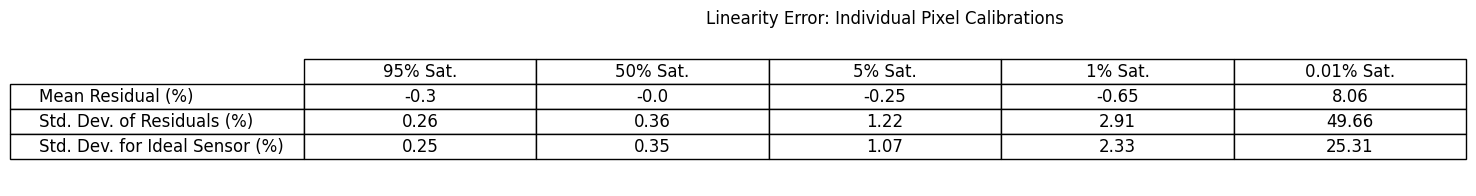

In [35]:
%matplotlib inline
# Data for the table
table_data = [
    [round(mu_errs[0], 2), round(mu_errs[1], 2), round(mu_errs[2], 2), round(mu_errs[3], 2), round(mu_errs[4], 2)],
    [round(sigma_errs[0], 2), round(sigma_errs[1], 2), round(sigma_errs[2], 2), round(sigma_errs[3], 2), round(sigma_errs[4], 2)],
    [round(sigma_expected[0], 2), round(sigma_expected[1], 2), round(sigma_expected[2], 2), round(sigma_expected[3], 2), round(sigma_expected[4], 2)]
]

# Column labels
column_labels = ["95% Sat.", "50% Sat.", "5% Sat.", "1% Sat.", "0.01% Sat."]
row_labels = ["Mean Residual (%)", "Std. Dev. of Residuals (%)", "Std. Dev. for Ideal Sensor (%)"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Linearity Error: Individual Pixel Calibrations')
# Display the table
plt.show()